# Abra_Data_exploration #

I initially experimented with multiple strategies by combining indicators Bollinger Bands, MACD, RSI, Z-score, and a Stop-Loss/Take-Profit mechanism to handle exits. However, during backtesting, I noticed unusually high profits, profit factor, and return-to-risk ratios. This indicated overfitting—even slight changes to any parameter led to drastically negative results.

After further testing and analysis, my final strategy includes MACD, Z-score, and RSI indicators integrated with a market-making strategy.
I came up with RSI and Z-score indicators as, I first plotted graphs on unsliced price data to observe how frequently they crossed standard boundaries. Based on this, I implemented: Z-score thresholds of ±1.5 and RSI thresholds of 35 (for oversold) and 65 (for overbought). These helped me buy low and sell high more reliably.
I also incorporated MACD crossovers to ensure more position changes and to trigger more trading opportunities. For buying and selling, I adopted a market-making strategy using spread.This approach ensured more returns during wider spreads. I experimented with different quote sizes and found values that balanced volume and profit effectively.

Additionally, I chose not to include Bollinger Bands in the final model since the graph analysis showed that the dataset was not too volatile for Bollinger. I ensured that the position limit of ±50 was maintained.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
prices = pd.read_csv('../AlgoTradingBacktester/data/ABRA/abra_price.csv')
prices.head()

,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3
0,0,1968,30,NaN,NaN,NaN,NaN,1971,30,NaN,NaN,NaN,NaN
1,1,1969,4,1967.0,31.0,NaN,NaN,1971,31,NaN,NaN,NaN,NaN
2,2,1966,1,1965.0,21.0,NaN,NaN,1969,22,NaN,NaN,NaN,NaN
3,3,1965,25,NaN,NaN,NaN,NaN,1968,25,NaN,NaN,NaN,NaN
4,4,1966,25,NaN,NaN,NaN,NaN,1968,6,1969.0,25.0,NaN,NaN


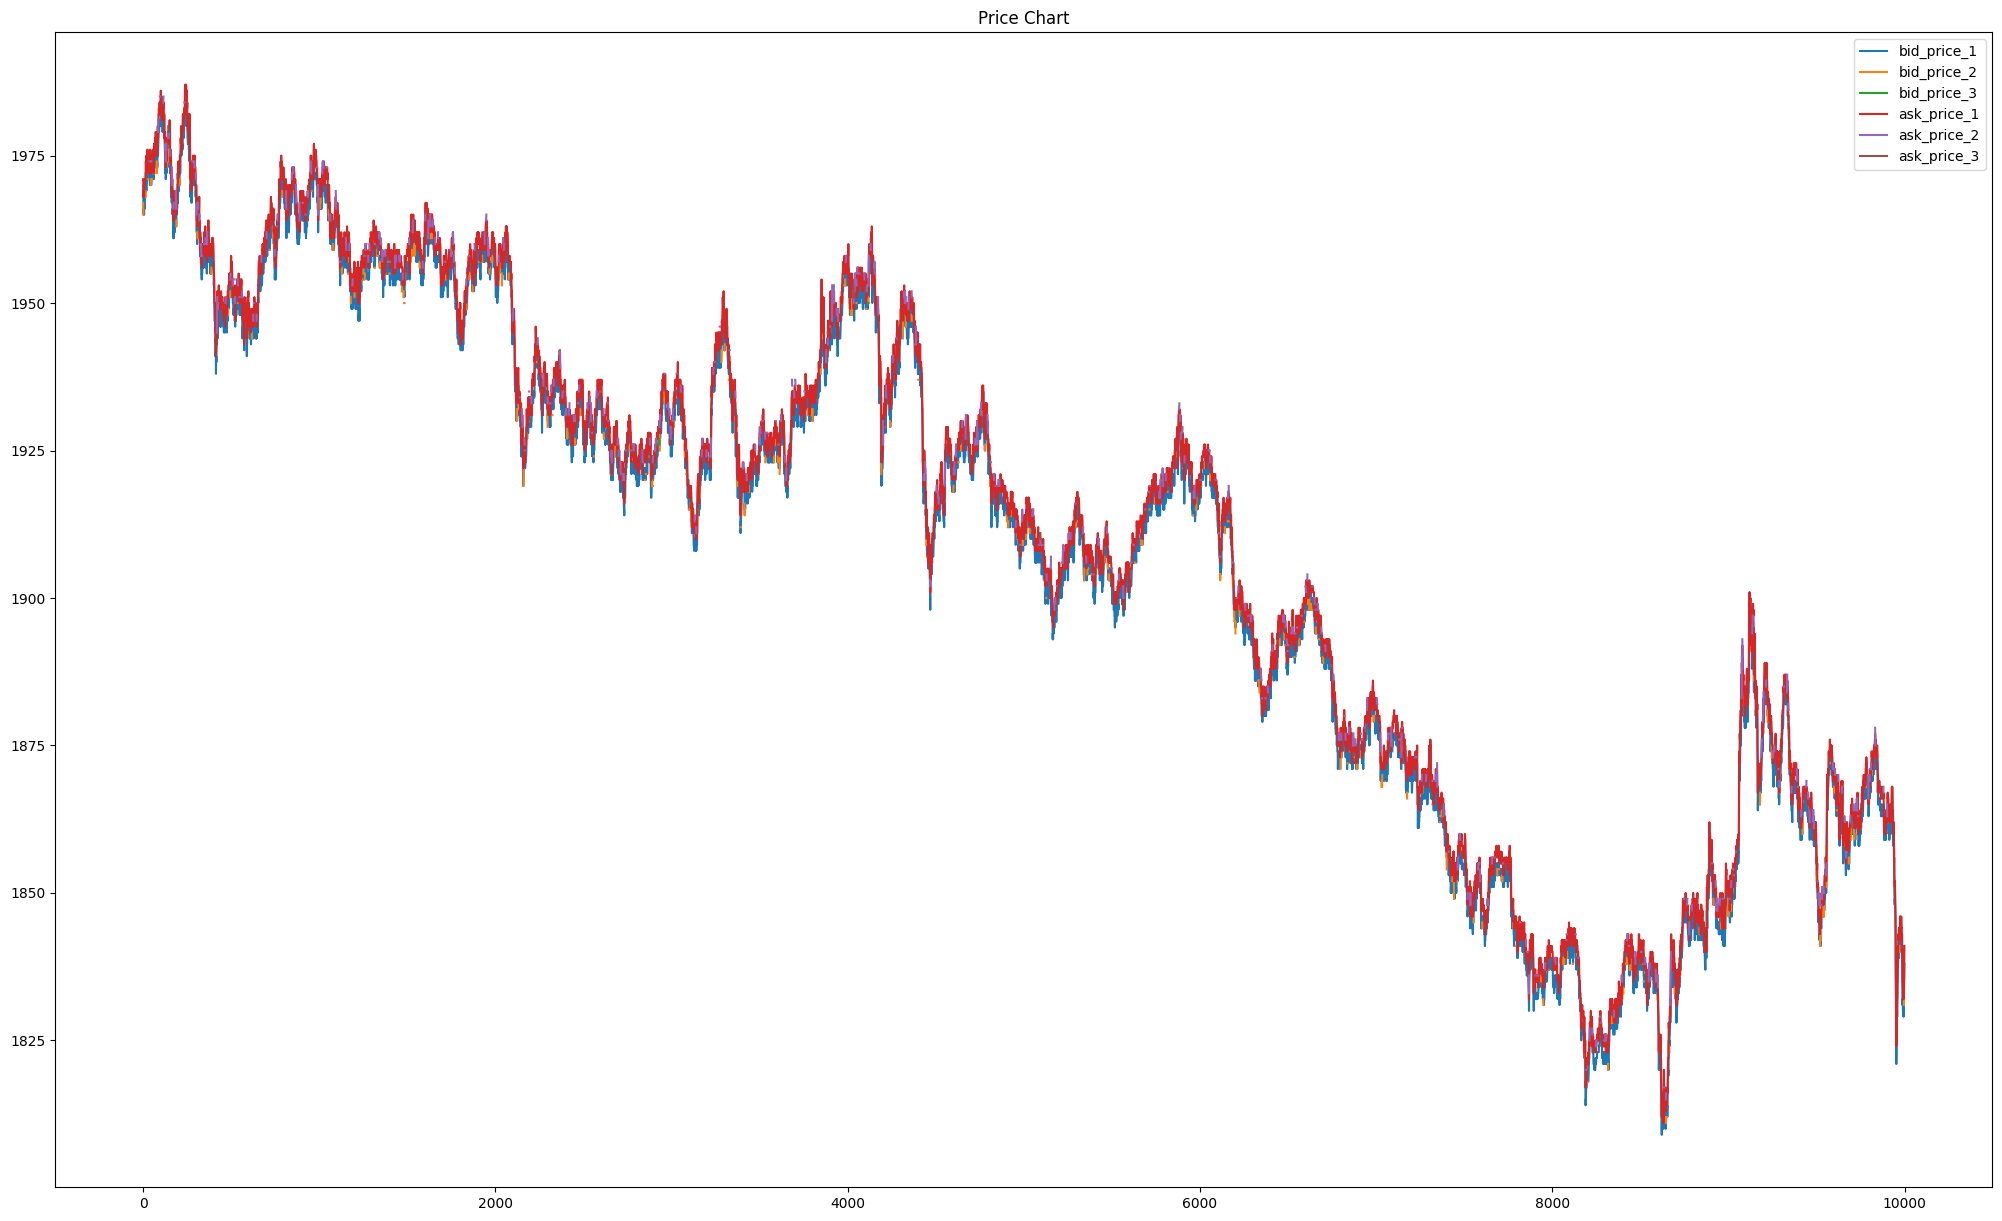

In [4]:
ts = prices['timestamp']
bp1 = prices['bid_price_1']
bp2 = prices['bid_price_2']
bp3 = prices['bid_price_3']
# bv1 = prices['bid_volume_1']
# bv2 = prices['bid_volume_2']
# bv3 = prices['bid_volume_3']
ap1 = prices['ask_price_1']
ap2 = prices['ask_price_2']
ap3 = prices['ask_price_3']
# av1 = prices['ask_volume_1']
# av2 = prices['ask_volume_2']
# av3 = prices['ask_volume_3']

plt.figure(figsize=(25,15))
price_dict = {
    'bid_price_1': bp1,
    'bid_price_2': bp2,
    'bid_price_3': bp3,
    'ask_price_1': ap1,
    'ask_price_2': ap2,
    'ask_price_3': ap3,
}

for label, price_series in price_dict.items():
    plt.plot(ts, price_series, label=label)
plt.title('Price Chart')
plt.legend()
plt.show()

In [3]:
prices_sliced=prices.iloc[1000:1500].copy()

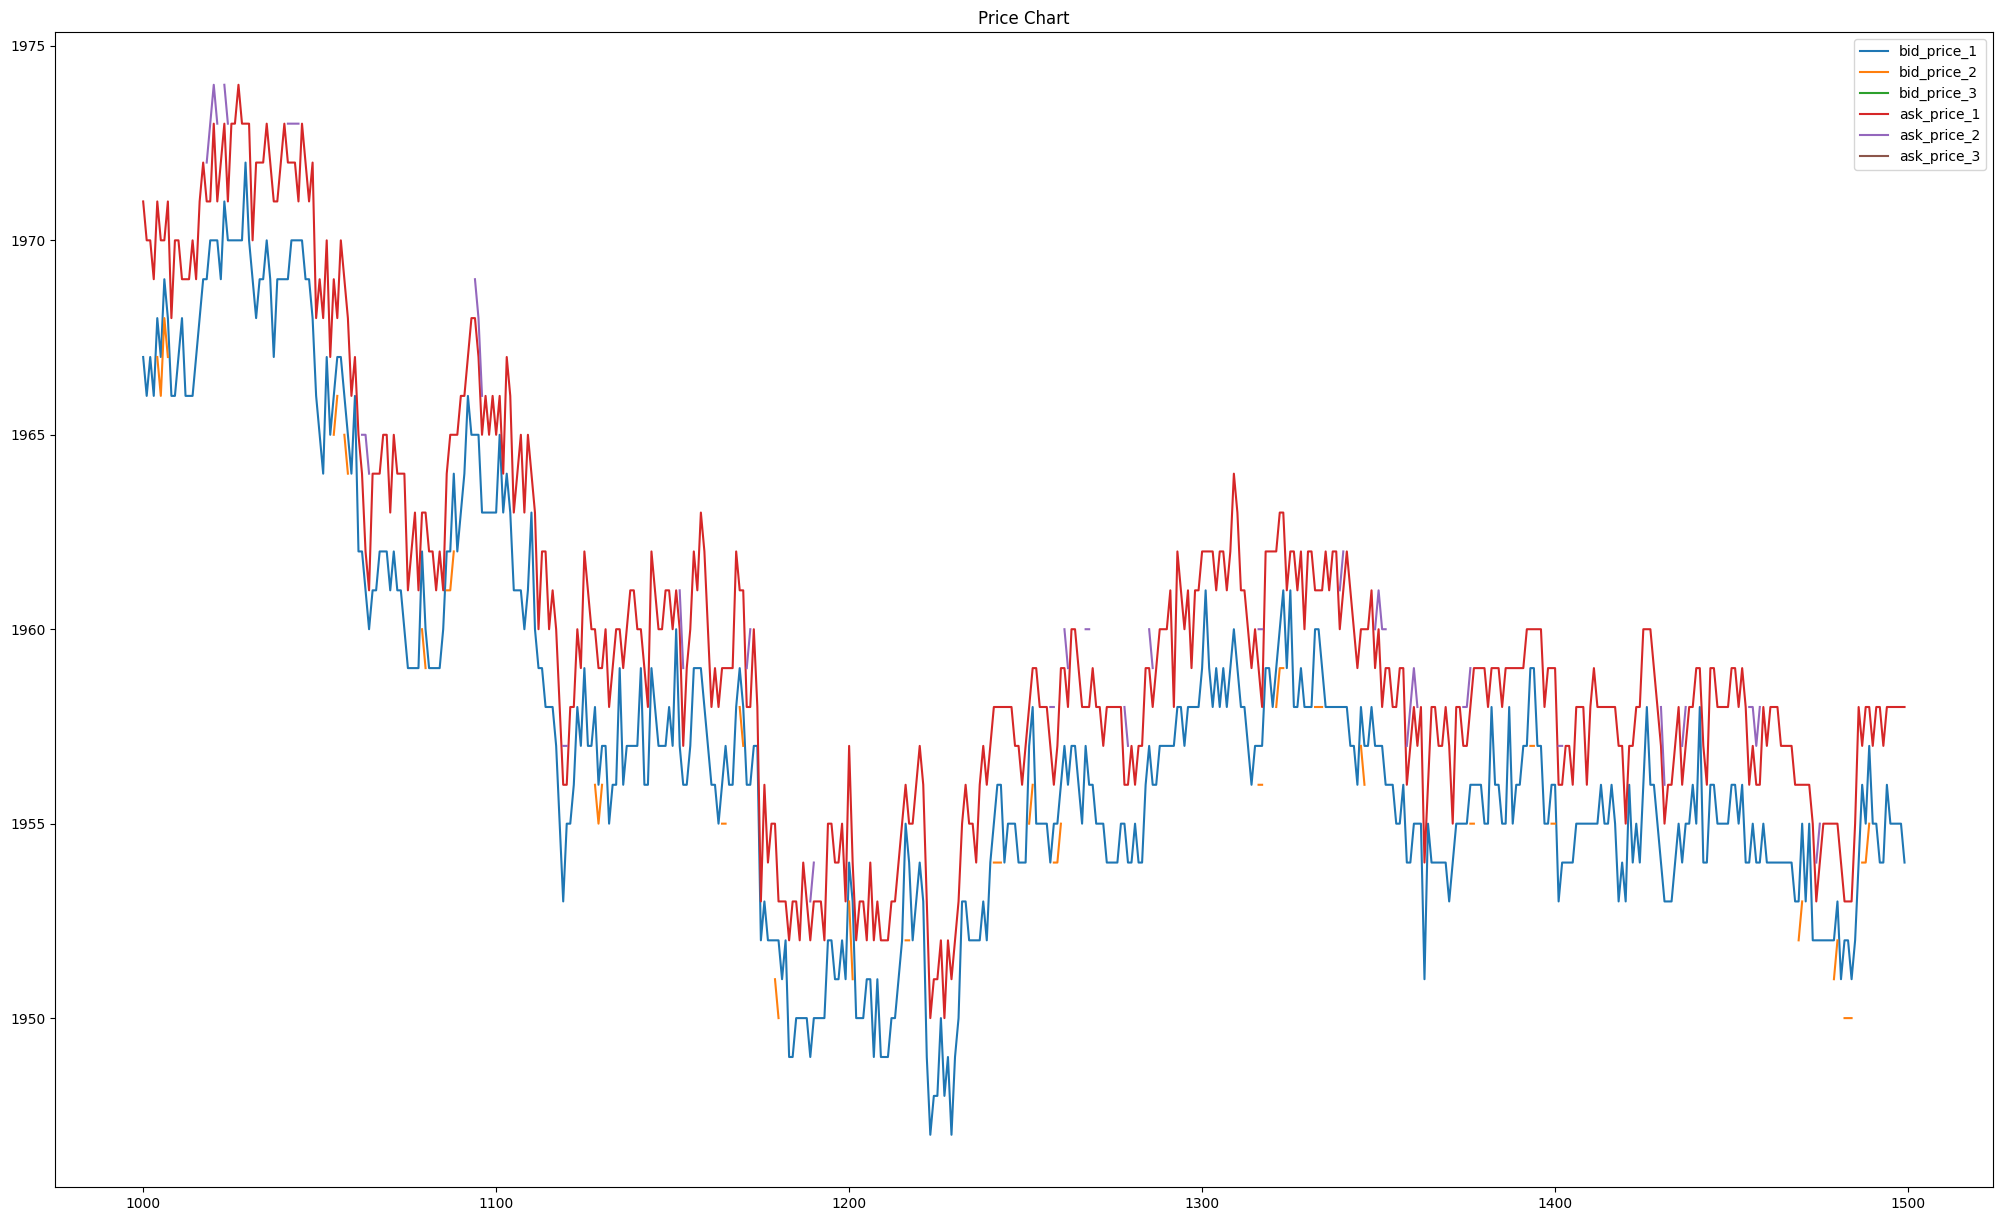

In [4]:
ts = prices_sliced['timestamp']
bp1 = prices_sliced['bid_price_1']
bp2 = prices_sliced['bid_price_2']
bp3 = prices_sliced['bid_price_3']
ap1 = prices_sliced['ask_price_1']
ap2 = prices_sliced['ask_price_2']
ap3 = prices_sliced['ask_price_3']

plt.figure(figsize=(25,15))
price_dict = {
    'bid_price_1': bp1,
    'bid_price_2': bp2,
    'bid_price_3': bp3,
    'ask_price_1': ap1,
    'ask_price_2': ap2,
    'ask_price_3': ap3,
}

for label, price_series in price_dict.items():
    plt.plot(ts, price_series, label=label)
plt.title('Price Chart')
plt.legend()
plt.show()

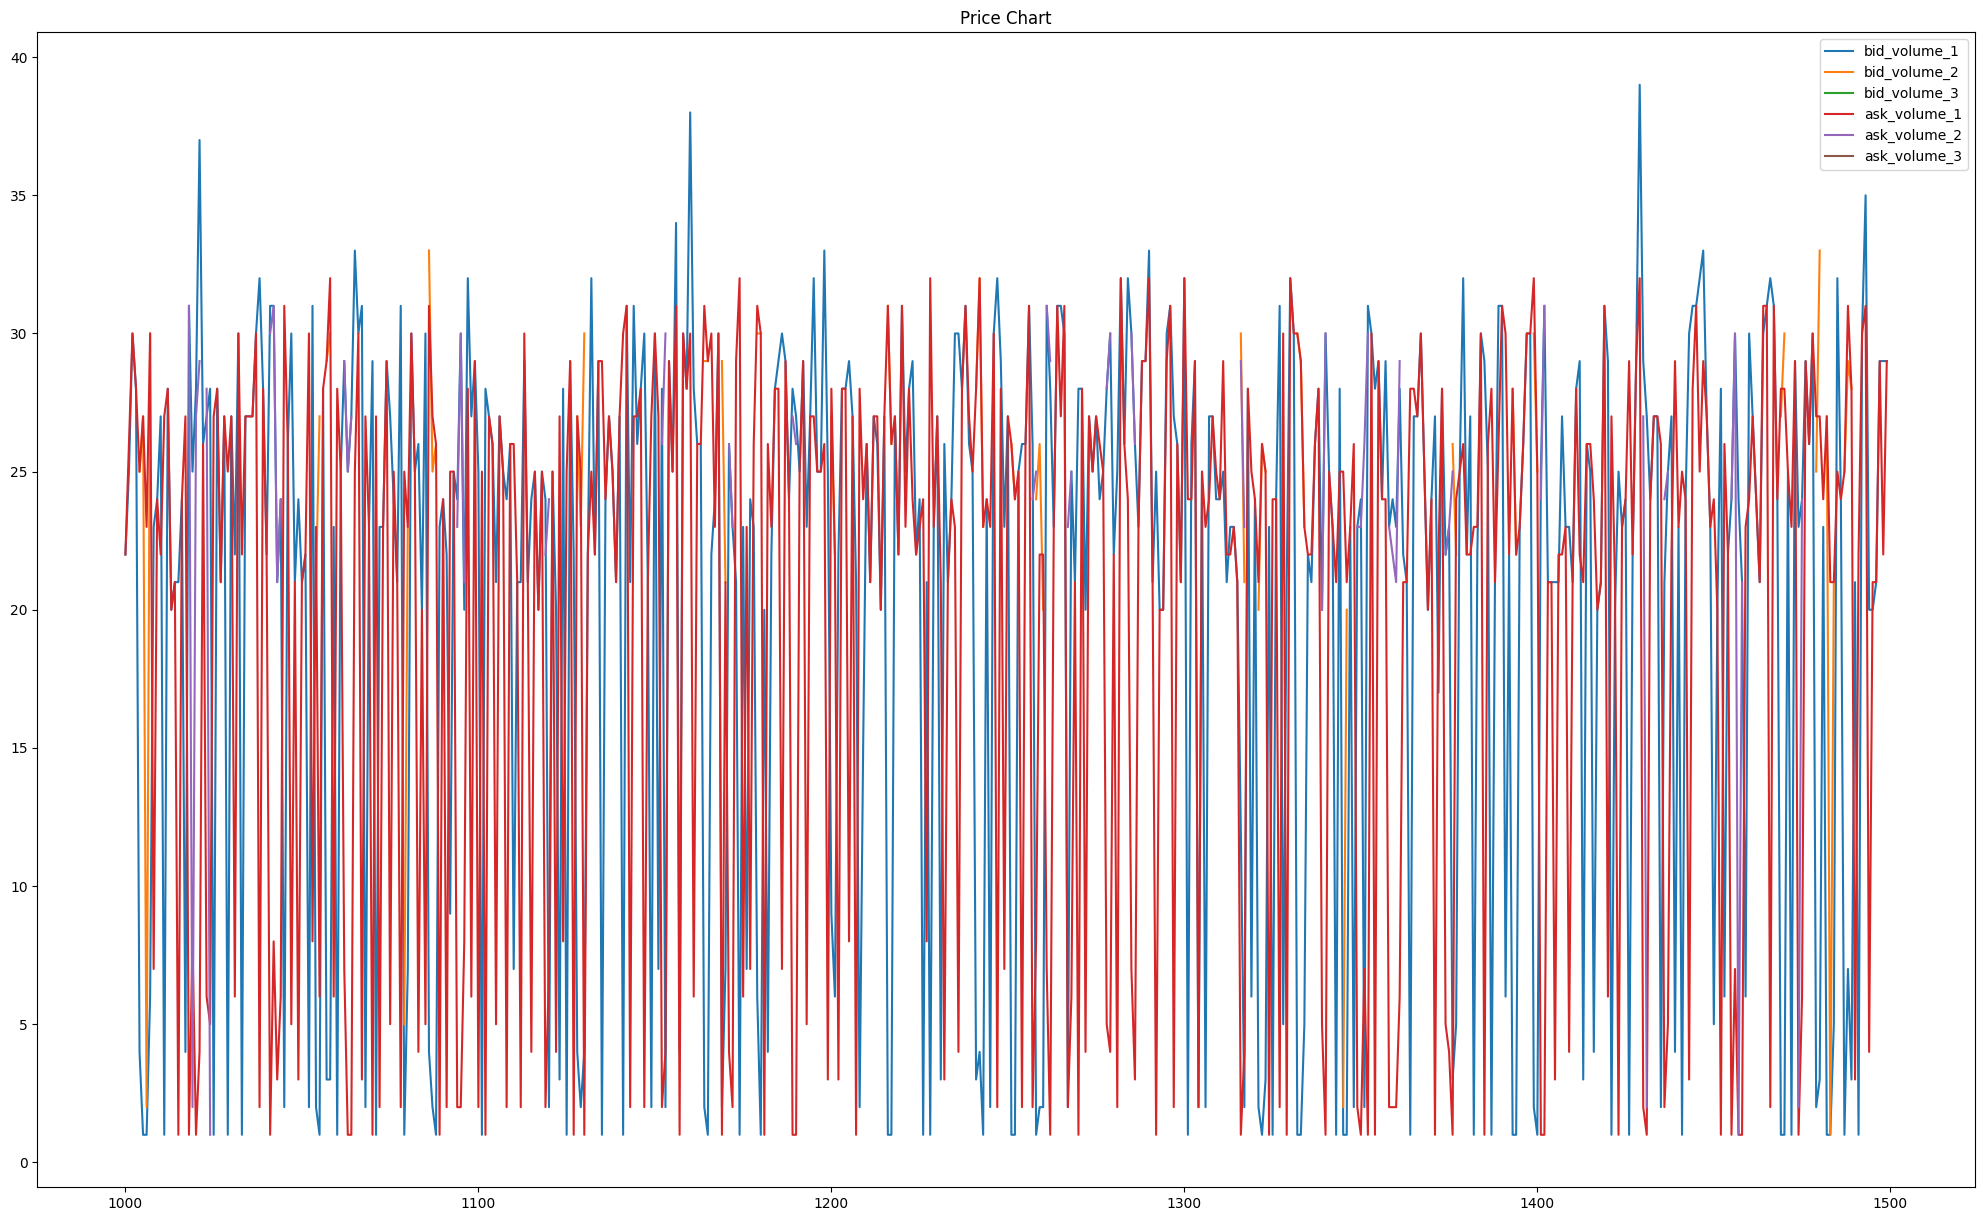

In [5]:
ts = prices_sliced['timestamp']
bv1 = prices_sliced['bid_volume_1']
bv2 = prices_sliced['bid_volume_2']
bv3 = prices_sliced['bid_volume_3']
av1 = prices_sliced['ask_volume_1']
av2 = prices_sliced['ask_volume_2']
av3 = prices_sliced['ask_volume_3']

plt.figure(figsize=(25,15))
price_dict = {
    'bid_volume_1': bv1,
    'bid_volume_2': bv2,
    'bid_volume_3': bv3,
    'ask_volume_1': av1,
    'ask_volume_2': av2,
    'ask_volume_3': av3,
}

for label, price_series in price_dict.items():
    plt.plot(ts, price_series, label=label)
plt.title('Price Chart')
plt.legend()
plt.show()

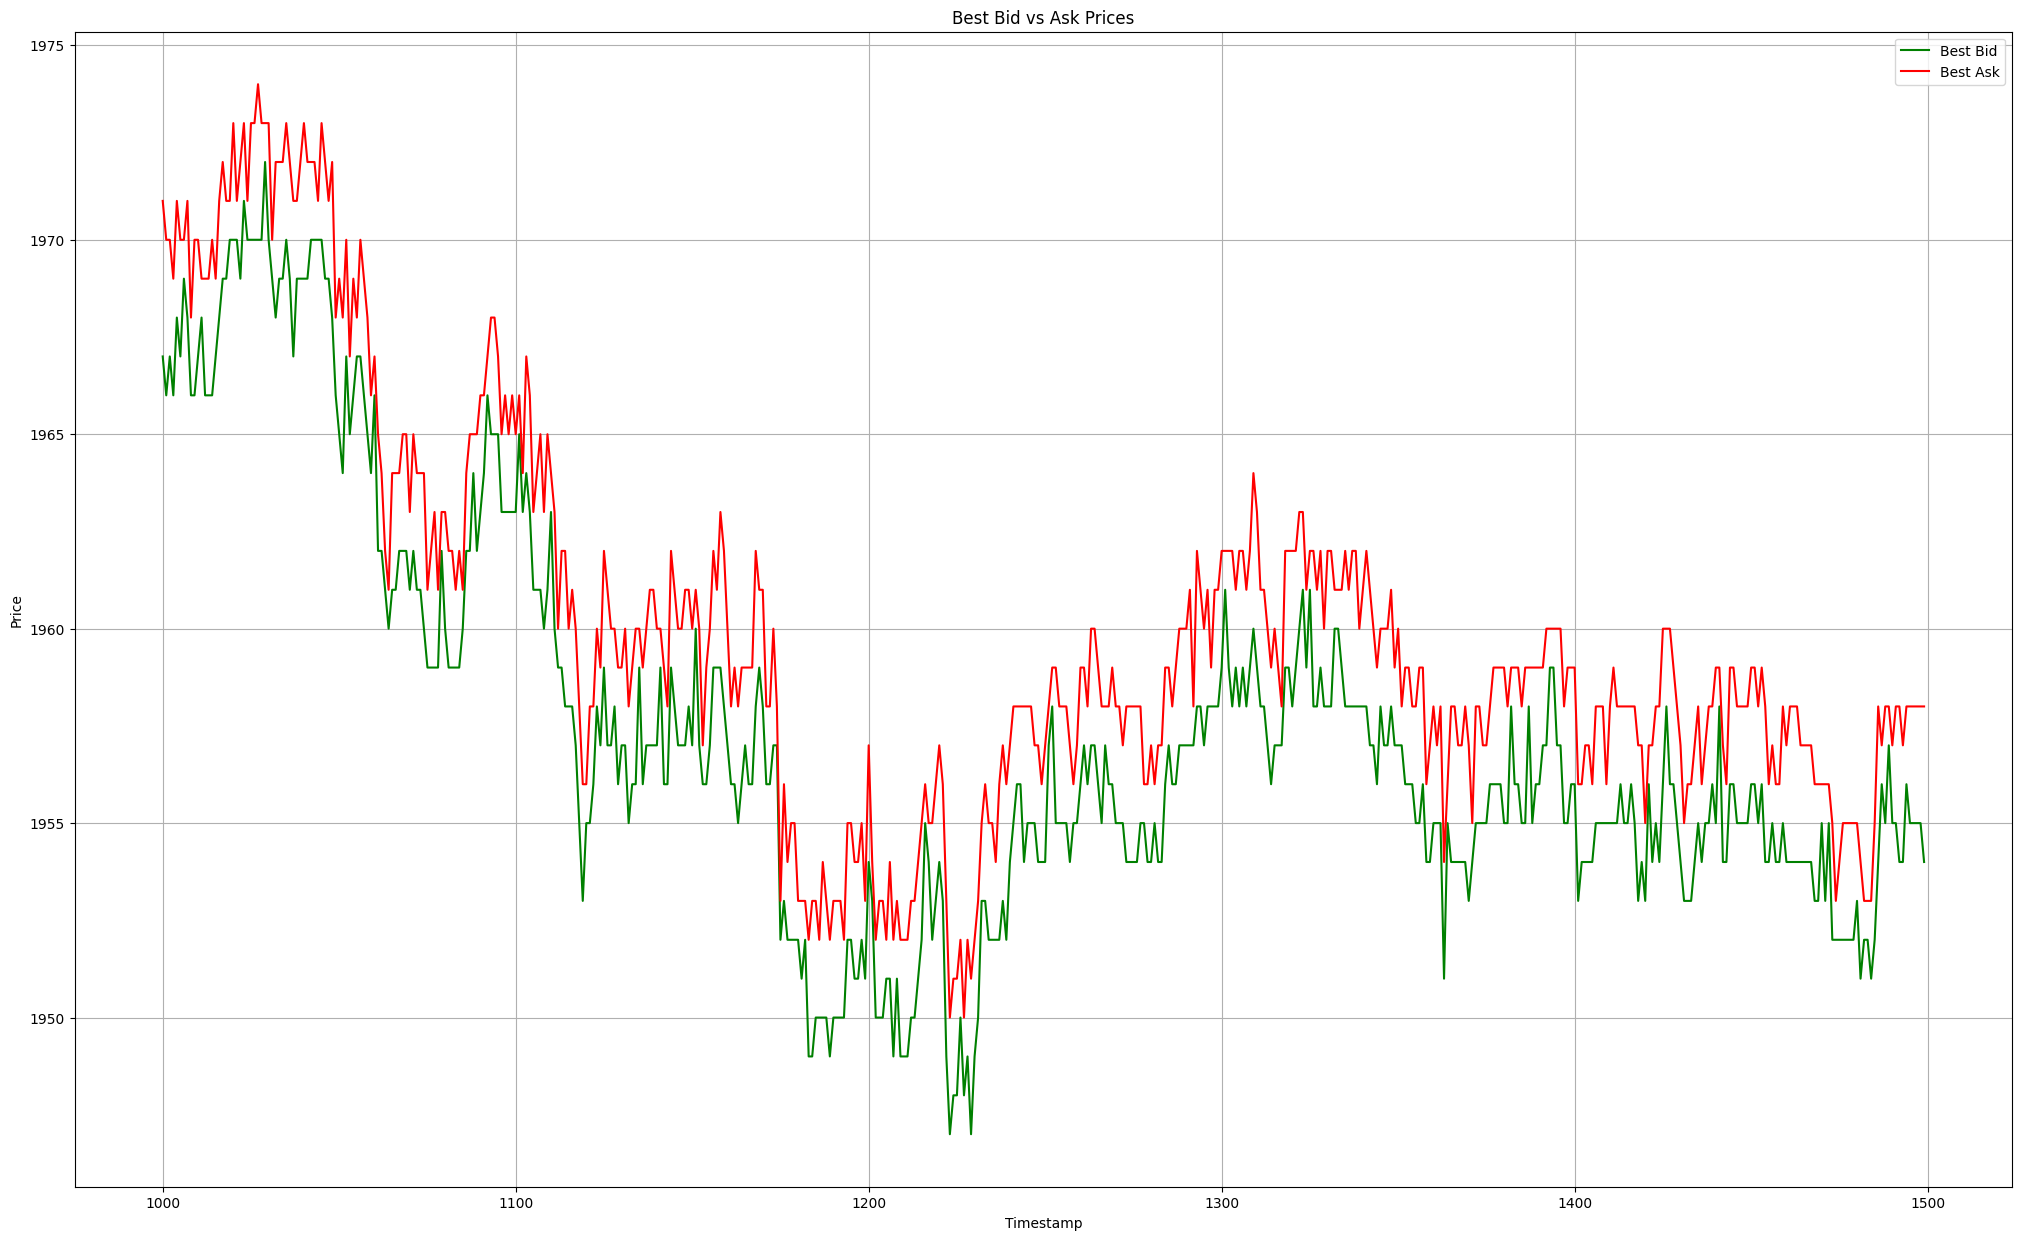

In [6]:
prices_sliced['bestbid'] = prices_sliced[['bid_price_1', 'bid_price_2', 'bid_price_3']].max(axis=1, skipna=True)
prices_sliced['bestask'] = prices_sliced[['ask_price_1', 'ask_price_2', 'ask_price_3']].min(axis=1, skipna=True)

plt.figure(figsize=(25, 15))
plt.plot(prices_sliced['timestamp'], prices_sliced['bestbid'], label='Best Bid', color='green')
plt.plot(prices_sliced['timestamp'], prices_sliced['bestask'], label='Best Ask', color='red')
plt.title('Best Bid vs Ask Prices')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# mean reversion

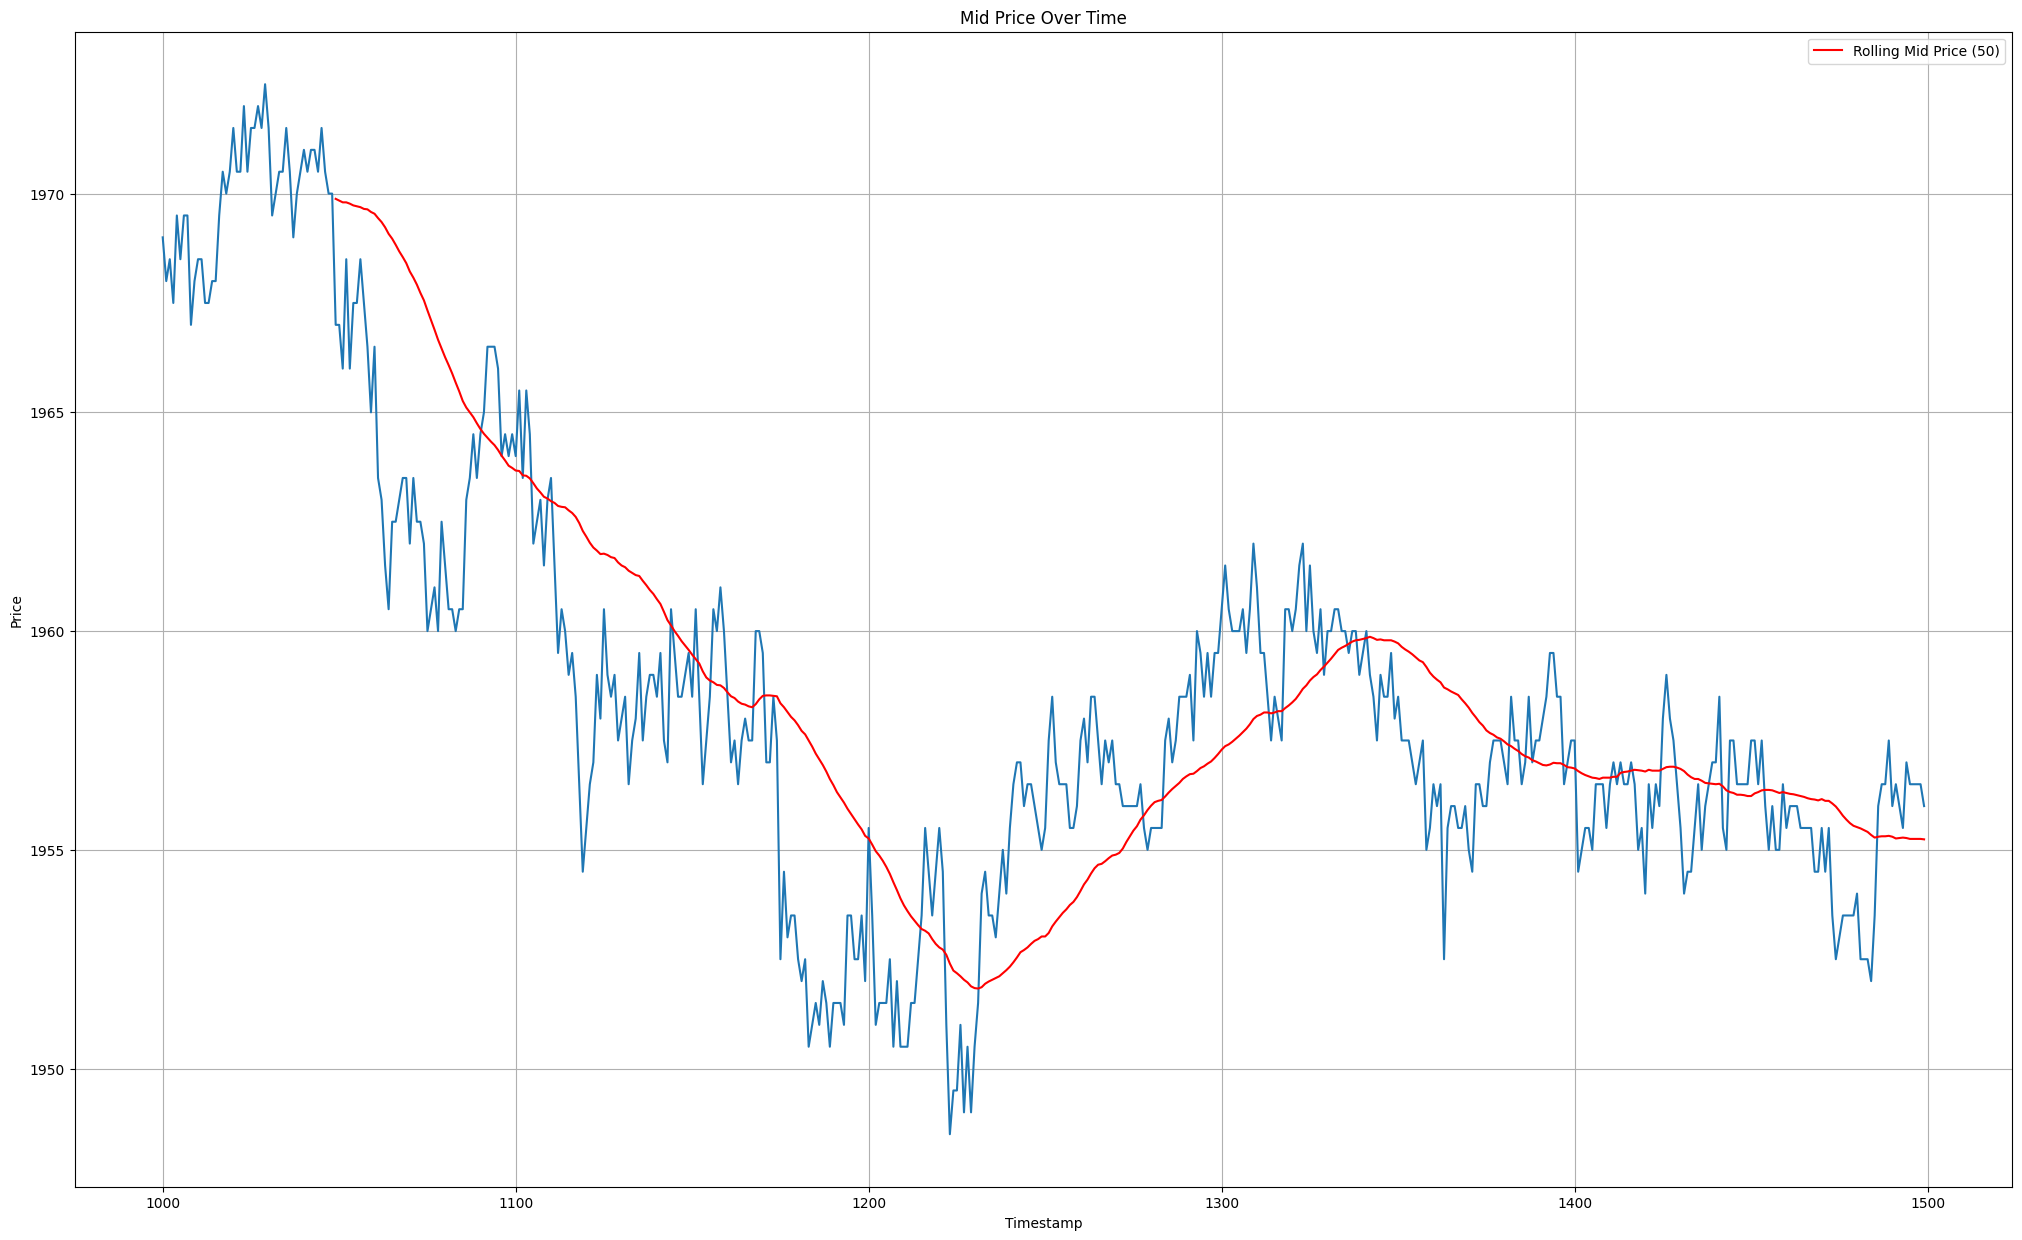

In [7]:
prices_sliced['mid_price'] = (prices_sliced['bestbid'] + prices_sliced['bestask']) / 2
prices_sliced['mid_roll'] = prices_sliced['mid_price'].rolling(50).mean()

plt.figure(figsize=(25,15))
plt.plot(prices_sliced['timestamp'], prices_sliced['mid_price'])
plt.plot(prices_sliced['timestamp'], prices_sliced['mid_roll'], label='Rolling Mid Price (50)', color='red')
plt.title("Mid Price Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

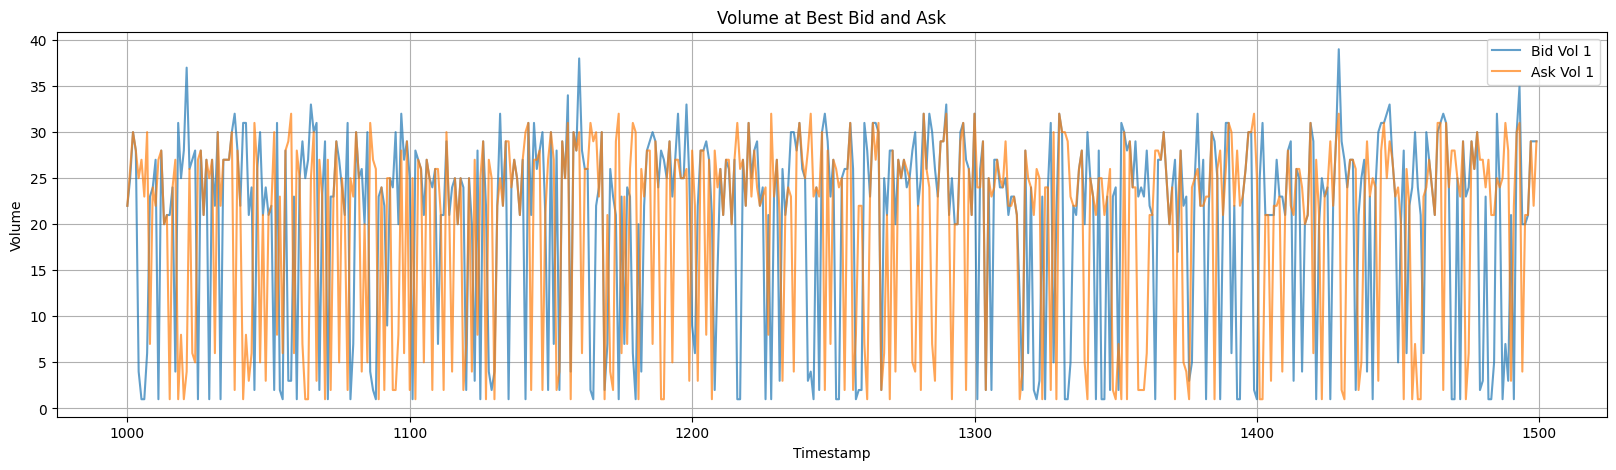

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(prices_sliced['timestamp'], prices_sliced['bid_volume_1'], label='Bid Vol 1', alpha=0.7)
plt.plot(prices_sliced['timestamp'], prices_sliced['ask_volume_1'], label='Ask Vol 1', alpha=0.7)
plt.title('Volume at Best Bid and Ask')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# market making strategy


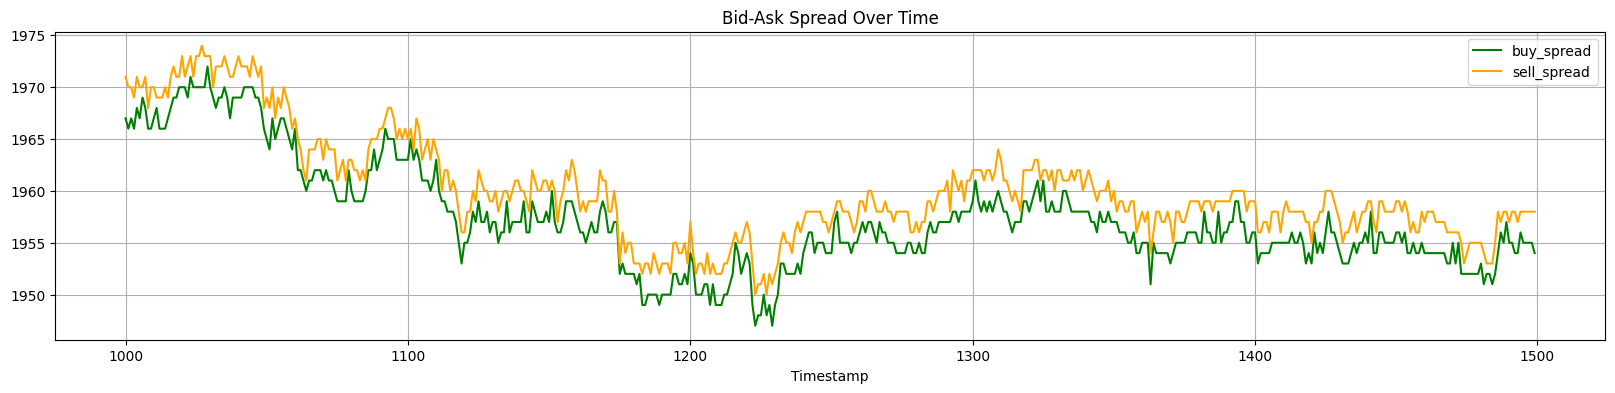

In [9]:
spread = prices_sliced['bestask'] - prices_sliced['bestbid']
plt.figure(figsize=(20, 4))
buy_spread=prices_sliced['mid_price']-(spread)/2
sell_spread=prices_sliced['mid_price']+(spread)/2
plt.plot(prices_sliced['timestamp'], buy_spread,color='green', label='buy_spread' )
plt.plot(prices_sliced['timestamp'], sell_spread,color='orange', label='sell_spread')
plt.title('Bid-Ask Spread Over Time')
plt.xlabel('Timestamp')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
trades = pd.read_csv('../AlgoTradingBacktester/data/abra_trades.csv')

plt.figure(figsize=(20, 6))
plt.plot(trades['timestamp'], trades['price'], label='prices')
plt.title('Trade Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Trade Price')
plt.grid(True)
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'AlgoTradingBacktester/data/abra_trades.csv'

# crossover moving average strategy


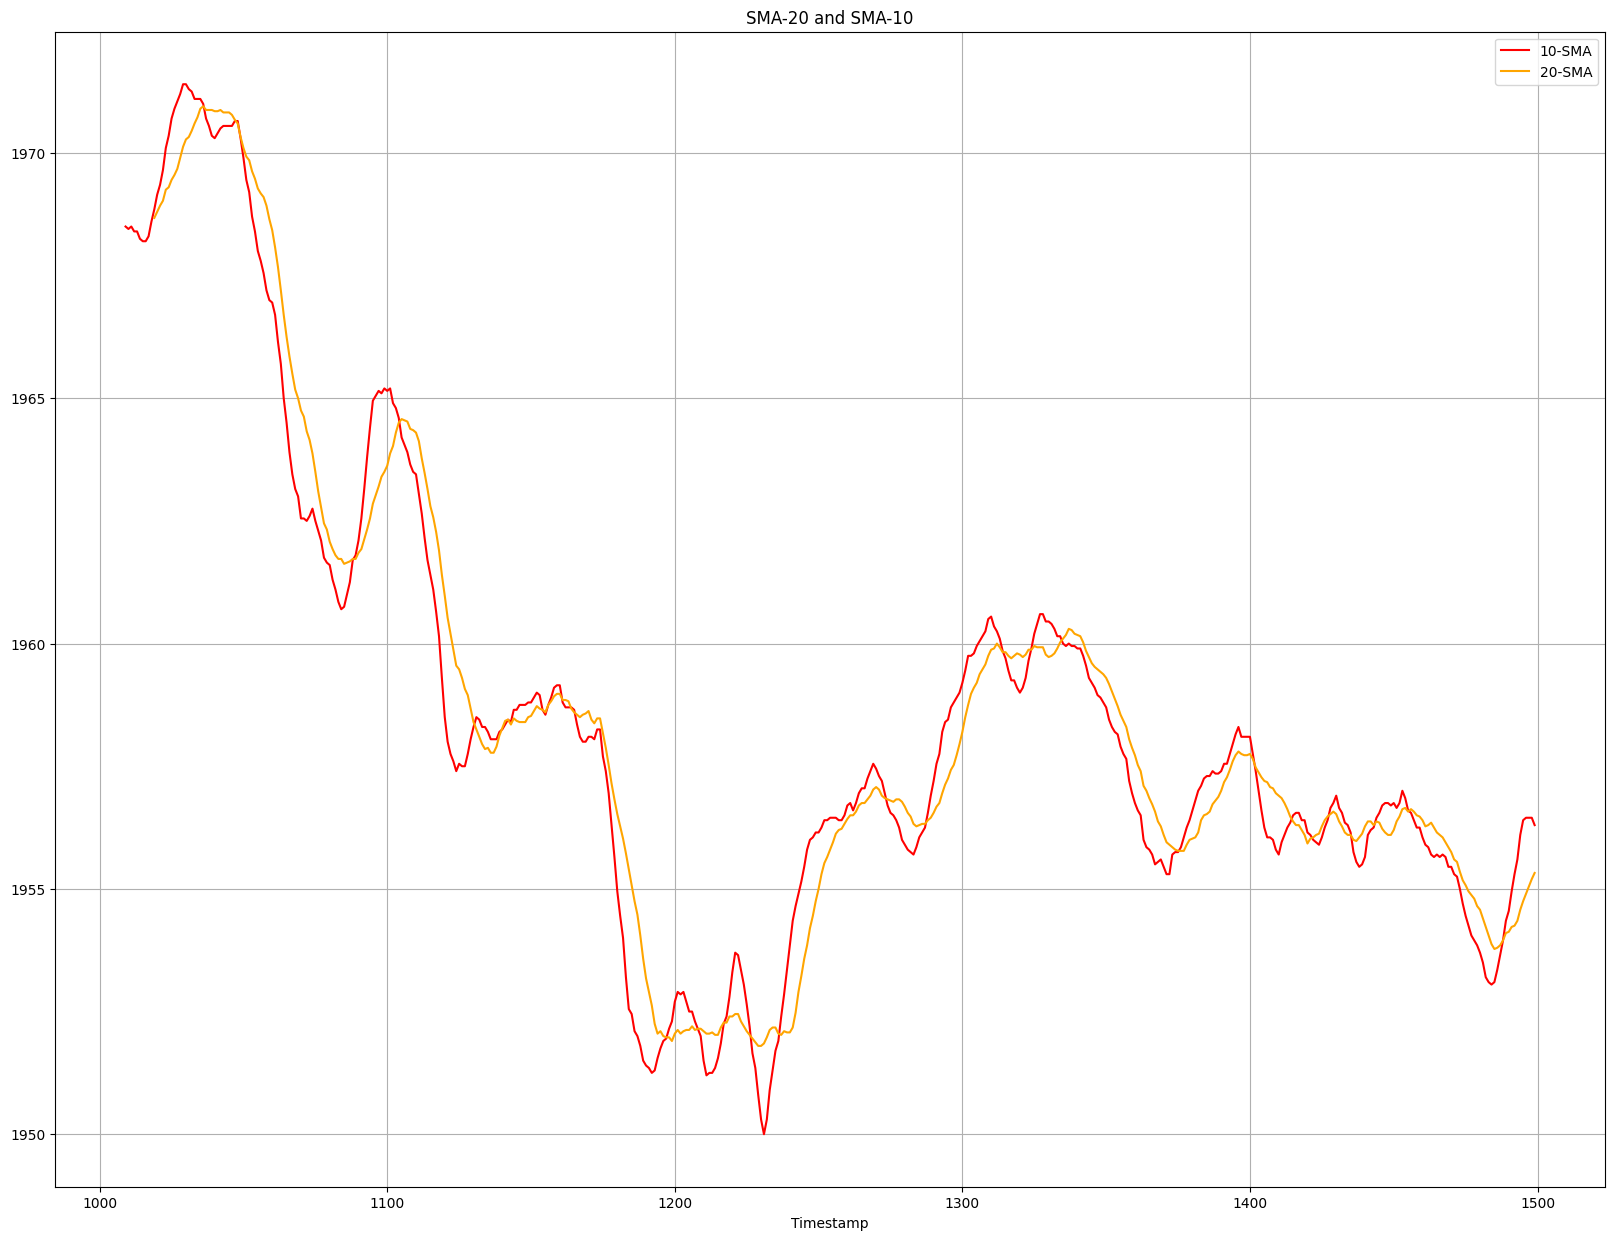

In [11]:
window = 20
prices_sliced['sma_10'] = prices_sliced['mid_price'].rolling(10).mean()
prices_sliced['sma_20'] = prices_sliced['mid_price'].rolling(window).mean()
prices_sliced['std_20'] = prices_sliced['mid_price'].rolling(window).std()


plt.figure(figsize=(20, 15))
plt.plot(prices_sliced['timestamp'], prices_sliced['sma_10'], label='10-SMA', color='red')
plt.plot(prices_sliced['timestamp'], prices_sliced['sma_20'], label='20-SMA', color='orange')
plt.title('SMA-20 and SMA-10')
plt.xlabel('Timestamp')
plt.grid(True)
plt.legend()
plt.show()

# bollinger bands

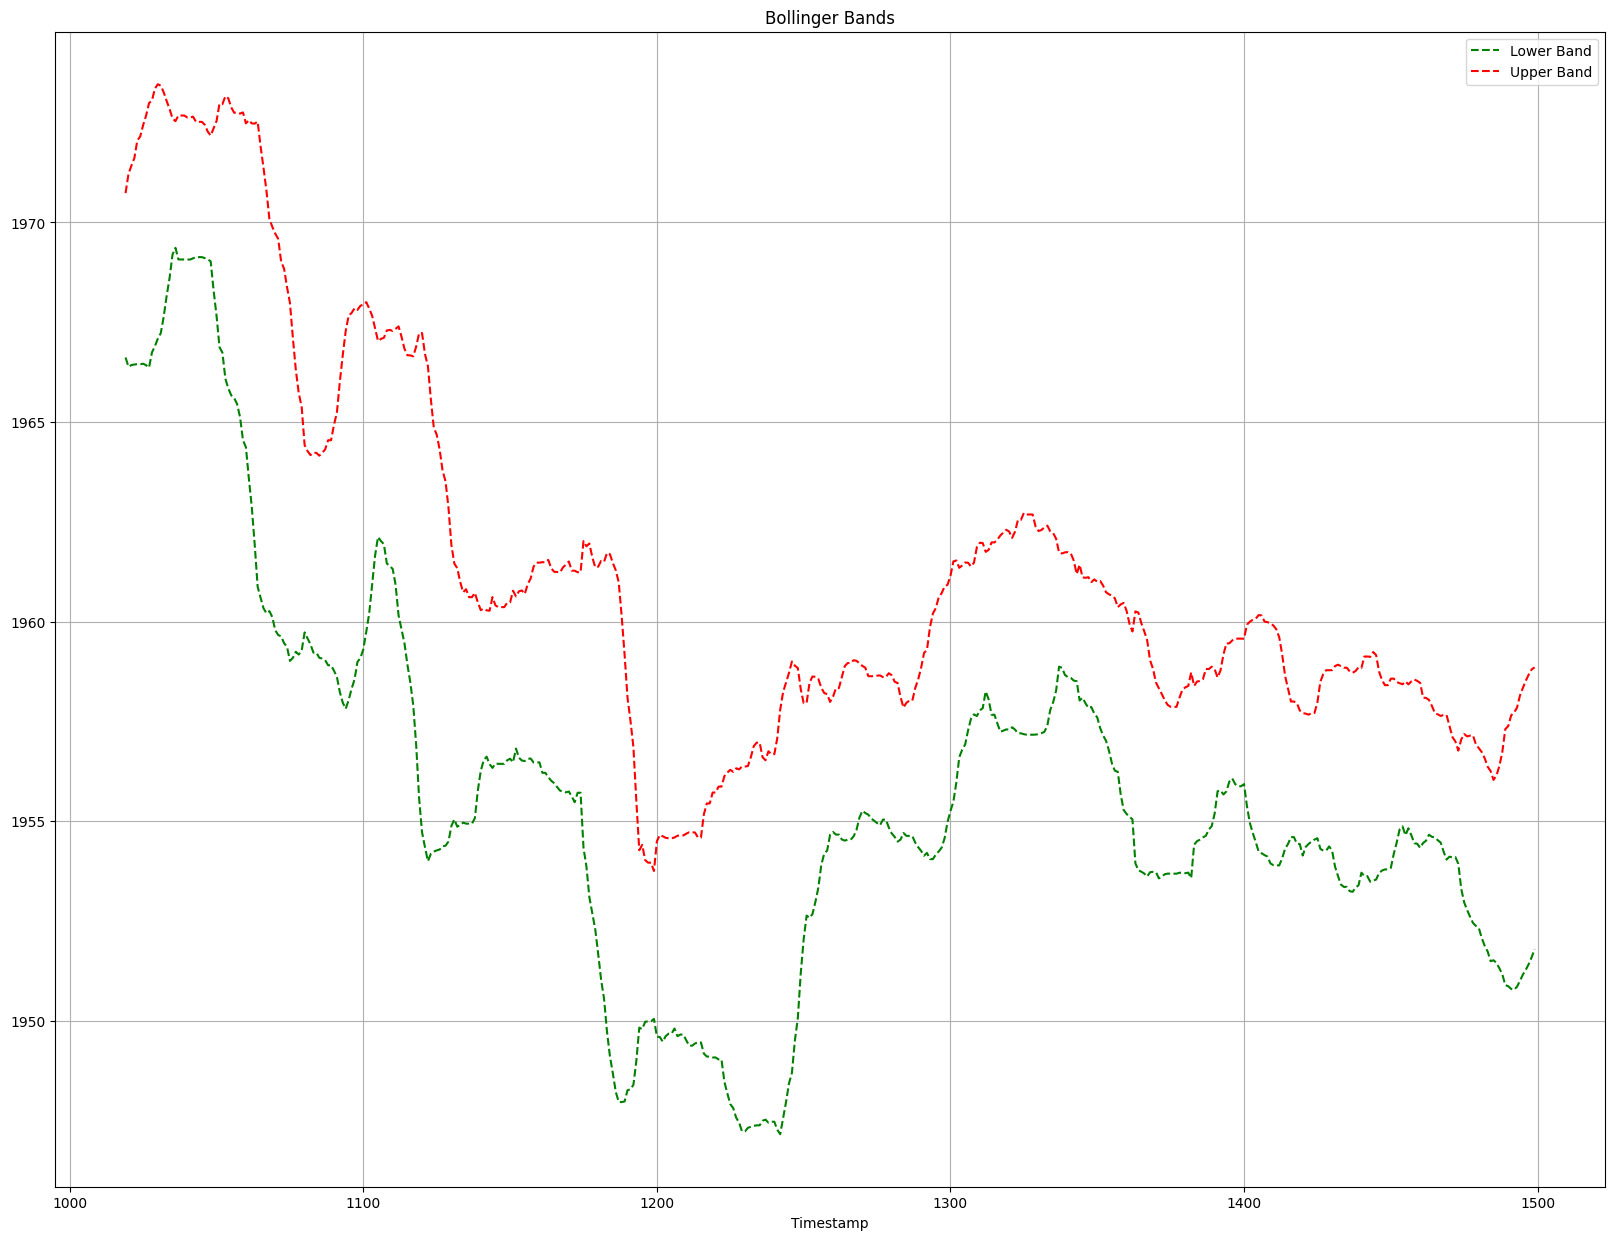

In [12]:

prices_sliced['upper_band'] = prices_sliced['sma_20'] + 2*prices_sliced['std_20']
prices_sliced['lower_band'] = prices_sliced['sma_20'] - 2*prices_sliced['std_20']

plt.figure(figsize=(20, 15))
plt.plot(prices_sliced['timestamp'], prices_sliced['lower_band'], label='Lower Band', linestyle='--', color='green')
plt.plot(prices_sliced['timestamp'], prices_sliced['upper_band'], label='Upper Band', linestyle='--', color='red')
plt.title('Bollinger Bands')
plt.xlabel('Timestamp')
plt.grid(True)
plt.legend()
plt.show()

# RSI

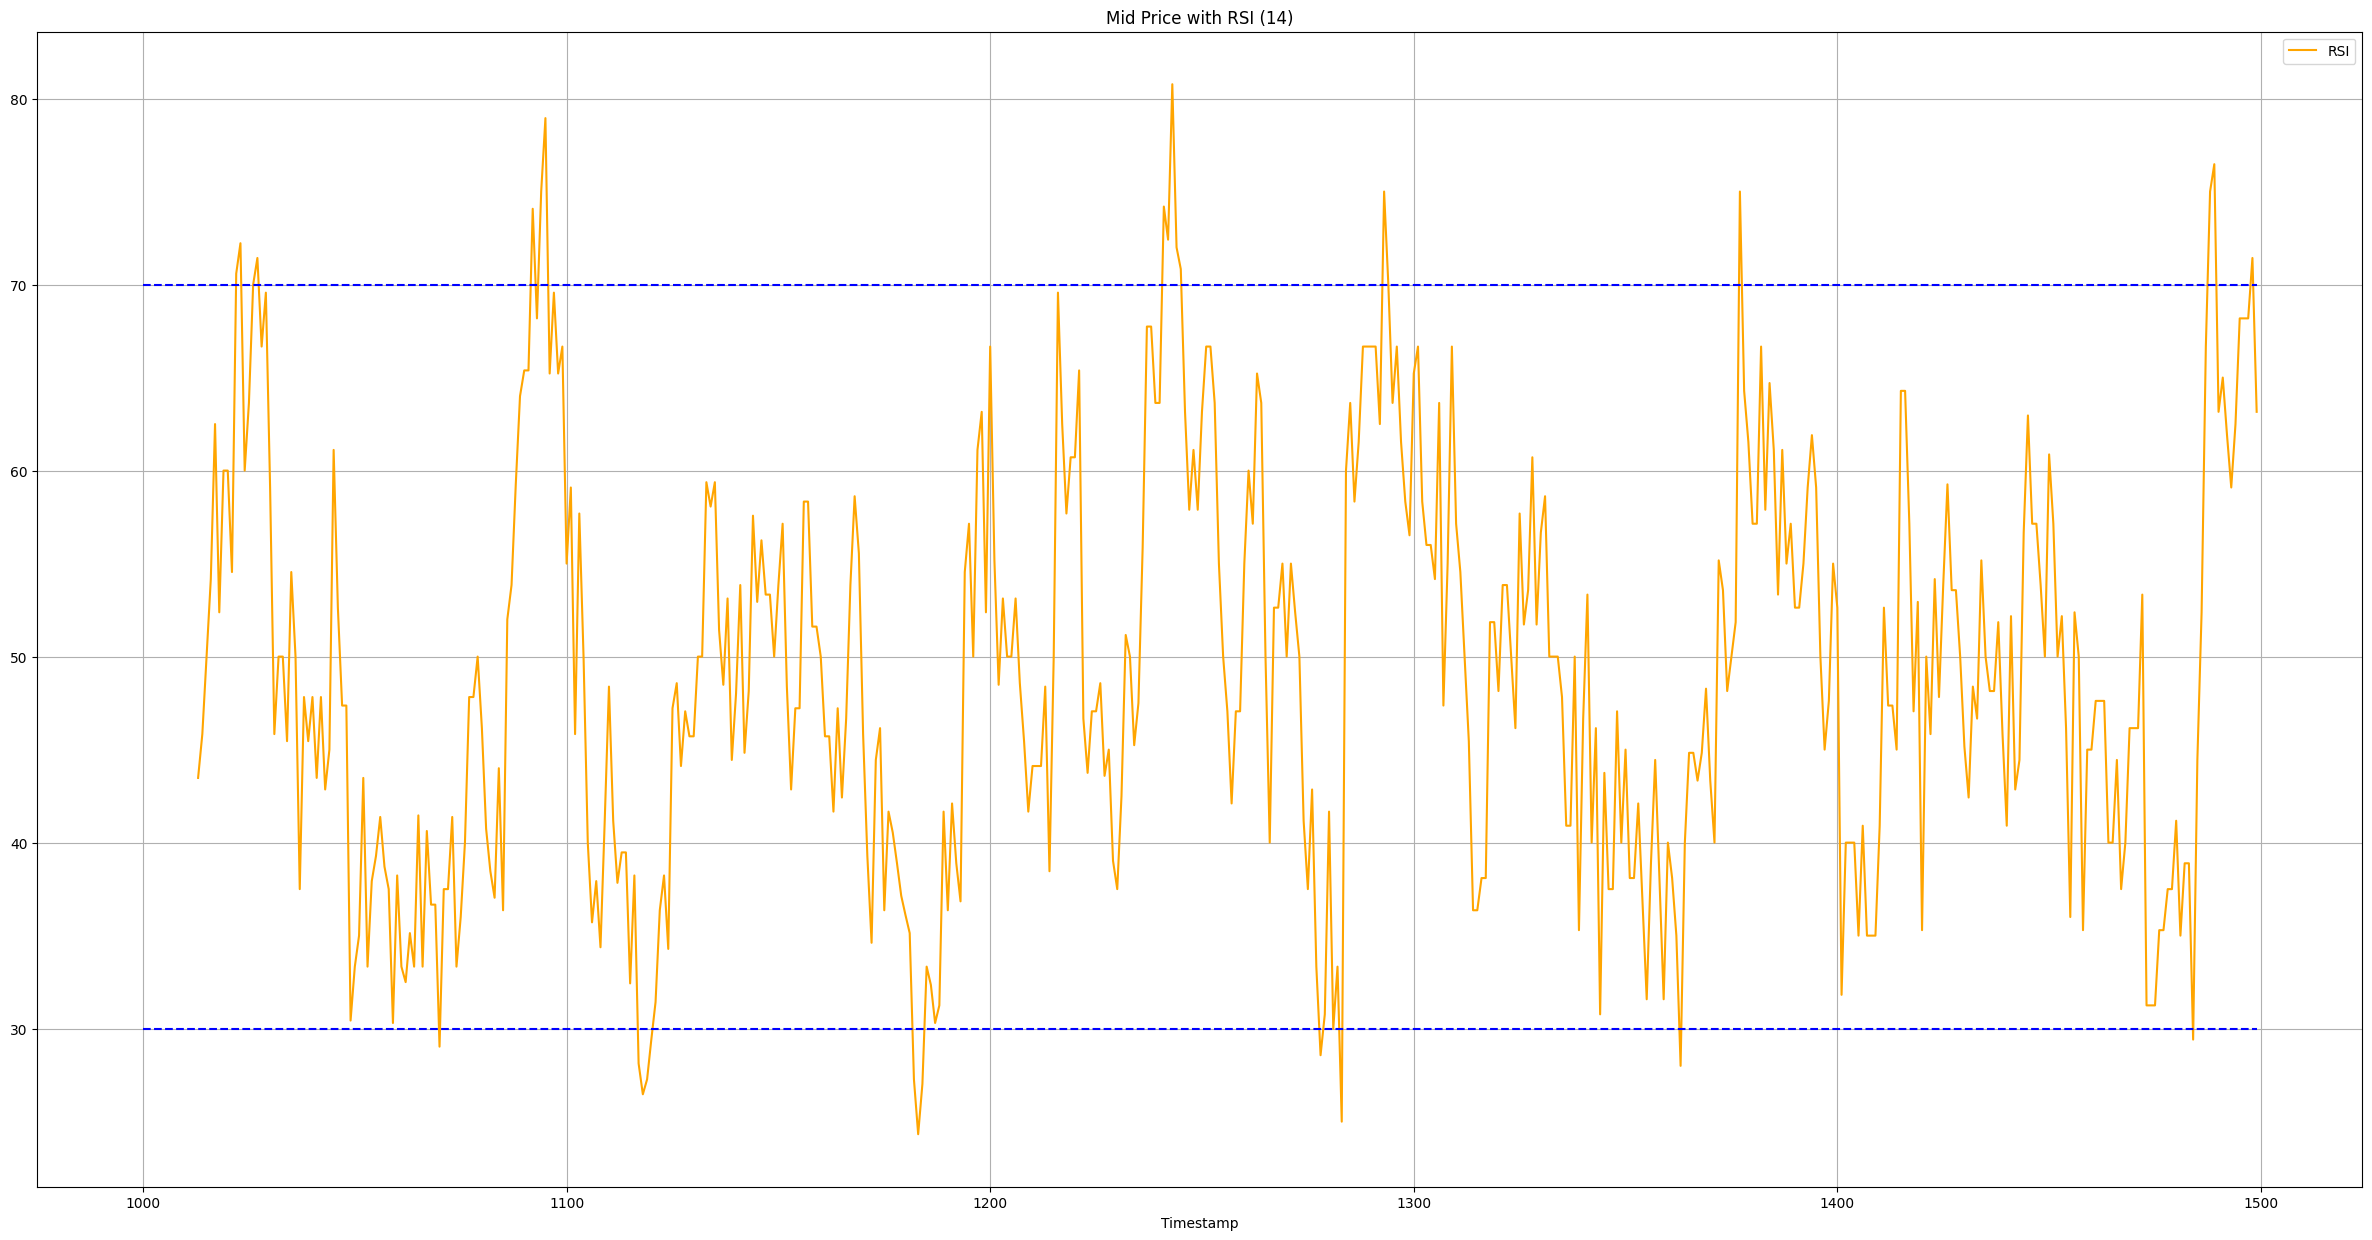

In [13]:
delta = prices_sliced['mid_price'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
prices_sliced['rsi'] = 100 - (100 / (1 + rs))
y1 = np.full_like(prices_sliced['rsi'], 70)
y2 = np.full_like(prices_sliced['rsi'], 30)
plt.figure(figsize=(30, 15))
plt.plot(prices_sliced['timestamp'], prices_sliced['rsi'], label='RSI', color='orange')
plt.plot(prices_sliced['timestamp'], y1 , 'b--')
plt.plot(prices_sliced['timestamp'], y2 , 'b--')
plt.title('Mid Price with RSI (14)')
plt.xlabel('Timestamp')
plt.grid(True)
plt.legend()
plt.show()

# Z-score

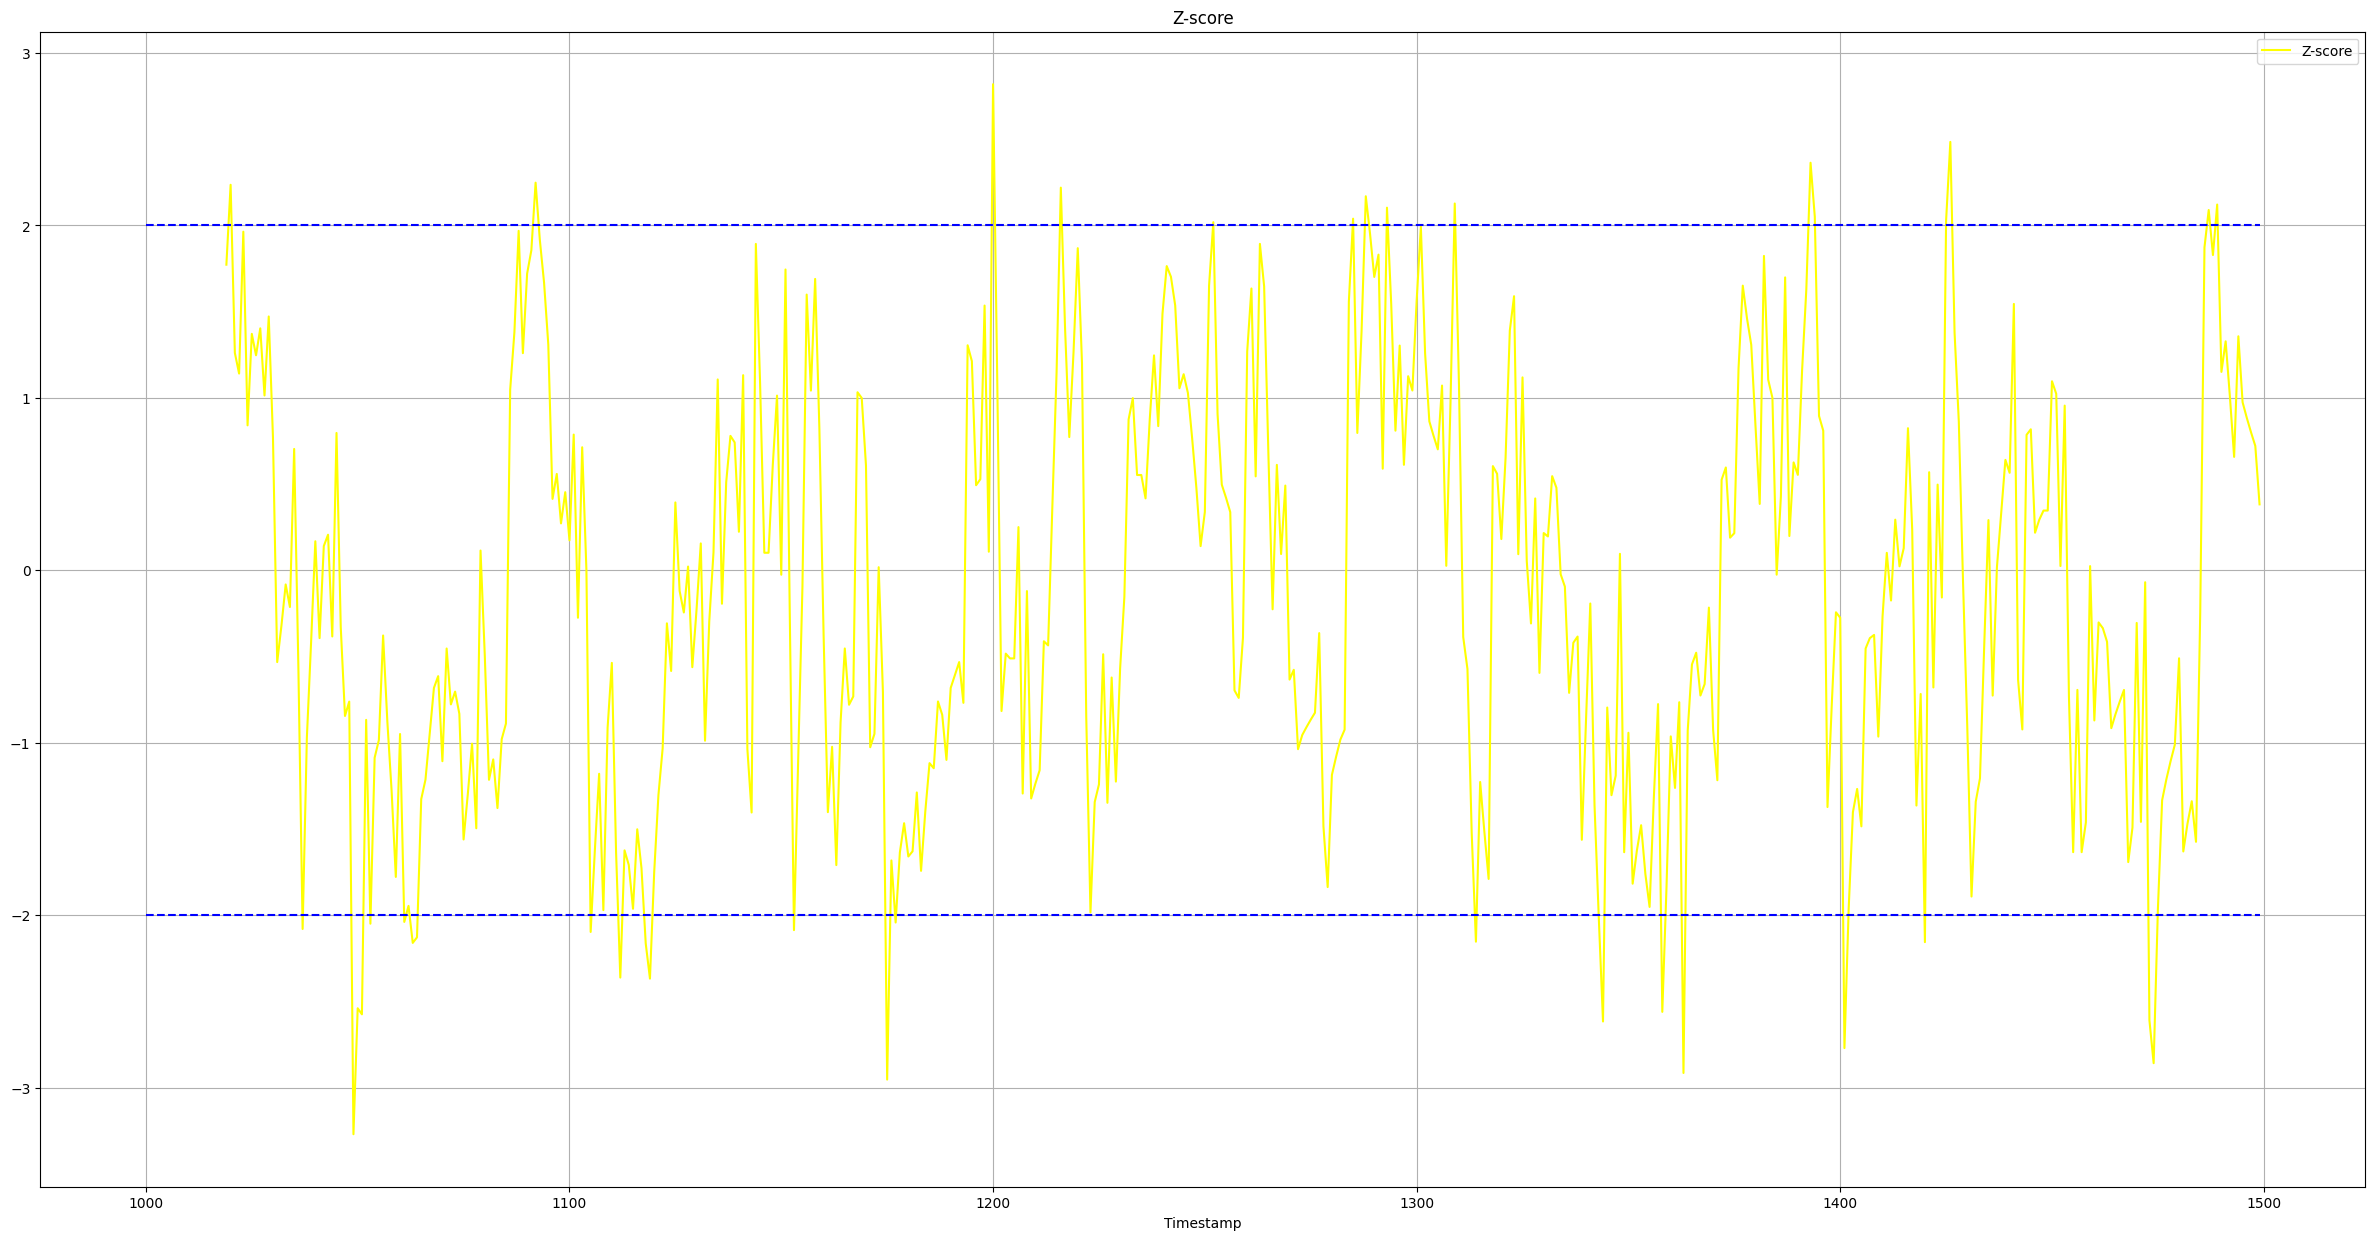

In [14]:
prices_sliced['z-score']= (prices_sliced['mid_price'] - prices_sliced['sma_20']) / prices_sliced['std_20']
y1 = np.full_like(prices_sliced['z-score'], 2)
y2 = np.full_like(prices_sliced['z-score'], -2)
plt.figure(figsize=(30, 15))
plt.plot(prices_sliced['timestamp'], prices_sliced['z-score'], label='Z-score', color='yellow')
plt.plot(prices_sliced['timestamp'], y1 , 'b--')
plt.plot(prices_sliced['timestamp'], y2 , 'b--')
plt.title('Z-score')
plt.xlabel('Timestamp')
plt.grid(True)
plt.legend()
plt.show()

# MACD

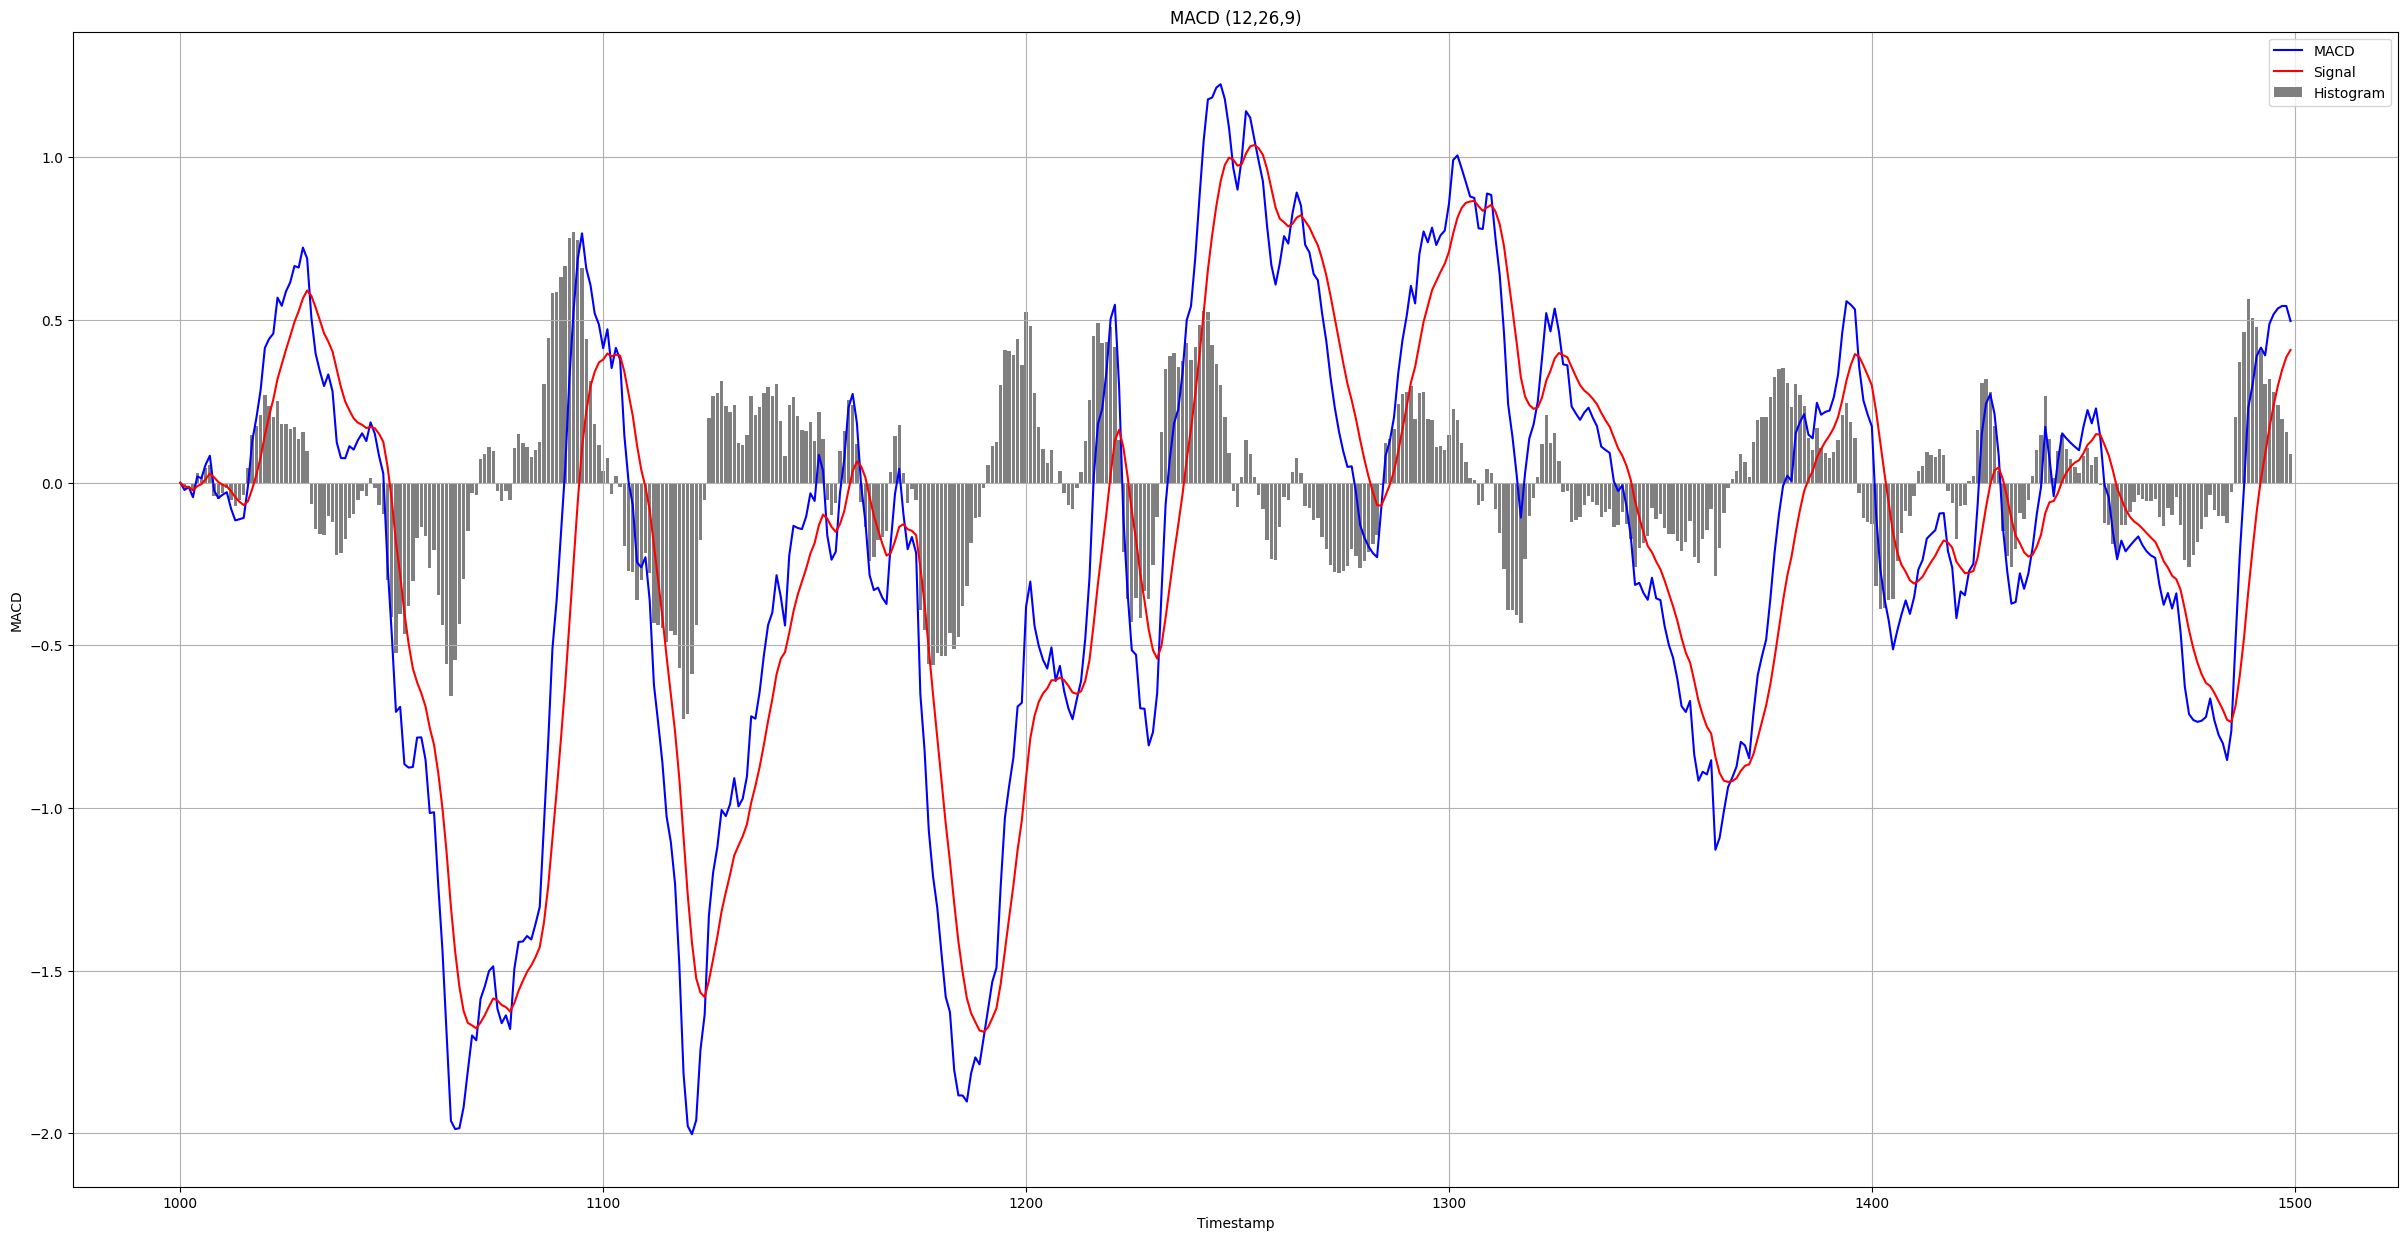

In [15]:
prices_sliced['ema_12'] = prices_sliced['mid_price'].ewm(span=12).mean()
prices_sliced['ema_26'] = prices_sliced['mid_price'].ewm(span=26).mean()
prices_sliced['macd'] = prices_sliced['ema_12'] - prices_sliced['ema_26']
prices_sliced['signal'] = prices_sliced['macd'].ewm(span=9).mean()

plt.figure(figsize=(30, 15))
plt.plot(prices_sliced['timestamp'], prices_sliced['macd'], label='MACD', color='blue')
plt.plot(prices_sliced['timestamp'], prices_sliced['signal'], label='Signal', color='red')
plt.bar(prices_sliced['timestamp'], prices_sliced['macd'] - prices_sliced['signal'], label='Histogram', color='grey')
plt.title('MACD (12,26,9)')
plt.ylabel('MACD')
plt.xlabel('Timestamp')
plt.grid(True)
plt.legend()
plt.show()